https://www.tensorflow.org/api_docs/python/tf/keras/layers

https://www.kaggle.com/code/kmader/what-is-convlstm

https://www.kaggle.com/code/shivamb/3d-convolutions-understanding-use-case

https://www.kaggle.com/code/saptarsi/regularizing-with-early-stopping

# Data Part

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# load data and labes
data_ow = np.load('OW_6s.npy')
data_ni = np.load('NI_6s.npy')
data_gi = np.load('GI_6s.npy')
data_gwi = np.load('GWI_6s.npy')
data_thinfi = np.load('ThinFI_6s.npy')
data_medfi = np.load('MediumFI_6s.npy')
data_thickfi = np.load('ThickFI_6s.npy')

labels_ow = np.loadtxt('OW_6s.txt')
labels_ni = np.loadtxt('NI_6s.txt')
labels_gi = np.loadtxt('GI_6s.txt')
labels_gwi = np.loadtxt('GWI_6s.txt')
labels_thinfi = np.loadtxt('ThinFI_6s.txt')
labels_medfi = np.loadtxt('MediumFI_6s.txt')
labels_thickfi = np.loadtxt('ThickFI_6s.txt')

# combine data and labels
data = np.concatenate((data_ow, data_ni, data_gi, data_gwi, data_thinfi, data_medfi, data_thickfi), axis=0)
labels = np.concatenate((labels_ow, labels_ni, labels_gi, labels_gwi, labels_thinfi, labels_medfi, labels_thickfi), axis=0)

# reshape the data (number of samples, time step, height, width, number of channels(HH & HV) )
data = data.reshape((data.shape[0], 6, 32, 32, 2))

num_classes = 7
labels = to_categorical(labels, num_classes) # categorize labels

# split train-val-test data with 8:1:1 ratio
## 1st split the data into training and temporary validation + test sets 8:2
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42) #42, The Hitchhiker's Guide to the Galaxy
## then split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#total
print("number of the data:", data.shape[0])
#check the train-val-test shapes
print("train shape:", X_train.shape)

number of the data: 164564
train shape: (131651, 6, 32, 32, 2)


# ConvLSTM
ConvLSTM model based on the paper https://www.mdpi.com/2072-4292/14/1/168


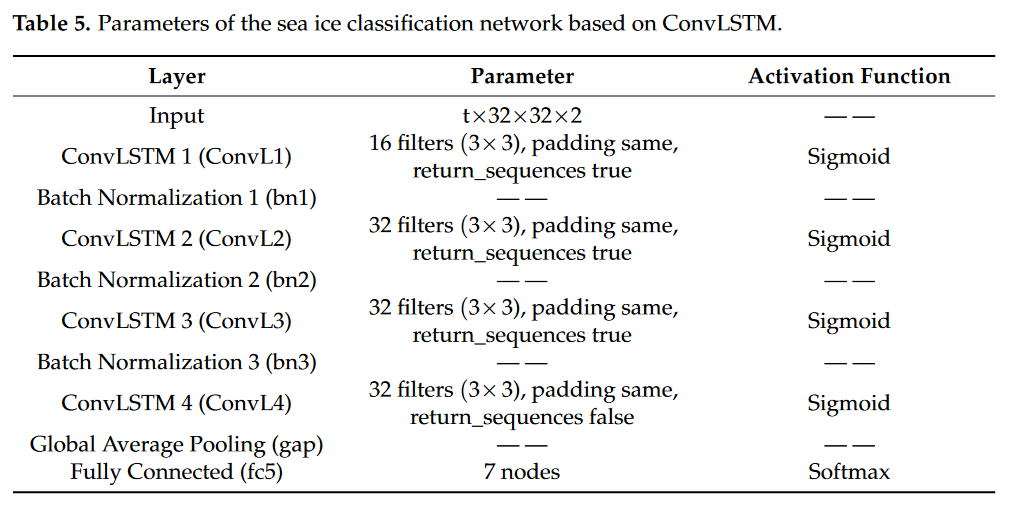

In [3]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, GlobalAveragePooling3D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential()

## ConvLSTM 1 (ConvL1)
model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True, activation='sigmoid', input_shape=(6, 32, 32, 2)))
model.add(BatchNormalization()) #this layer after ConvLSTM layer is to normalize the output of the ConvLSTM layer to speed up the training and avoid overfitting
model.add(Dropout(0.4)) #for overfitting prevention. this ratio damages accuracy to some extent, but prevents overfitting.

## ConvLSTM 2 (ConvL2)
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

## ConvLSTM 3 (ConvL3)
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

## ConvLSTM 4 (ConvL4)
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True, activation='sigmoid'))
model.add(BatchNormalization())

## Global Average Pooling (gap)
model.add(GlobalAveragePooling3D())

model.add(Dropout(0.4))

## fully connected (fc5)
model.add(Dense(7, activation='softmax'))


# model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model training
model.fit(X_train, y_train, epochs=10, batch_size=None, validation_data=(X_val, y_val), callbacks=[early_stop])


Epoch 1/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 1826s 442ms/step - accuracy: 0.8039 - loss: 0.4971 - val_accuracy: 0.8725 - val_loss: 0.3167
Epoch 2/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 1808s 439ms/step - accuracy: 0.8846 - loss: 0.2710 - val_accuracy: 0.8988 - val_loss: 0.2205
Epoch 3/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 1799s 437ms/step - accuracy: 0.9020 - loss: 0.2274 - val_accuracy: 0.4382 - val_loss: 4.7637
Epoch 4/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 1804s 438ms/step - accuracy: 0.9076 - loss: 0.2200 - val_accuracy: 0.6675 - val_loss: 1.4388
Epoch 5/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 1826s 444ms/step - accuracy: 0.9148 - loss: 0.2037 - val_accuracy: 0.5292 - val_loss: 3.1440


In [4]:
# evaluate the model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


515/515 ━━━━━━━━━━━━━━━━━━━━ 68s 132ms/step - accuracy: 0.8944 - loss: 0.2294
Test accuracy: 0.8937838077545166


In [5]:
# save the model
model.save('convLSTM_model.h5')


In [6]:
model.save('convLSTM_model.keras')

# 2D CNN - Conv2D

Conv2D model based on the paper https://www.mdpi.com/2072-4292/14/1/168

There is no detail in the paper, I am not sure about the transpose and reshape part

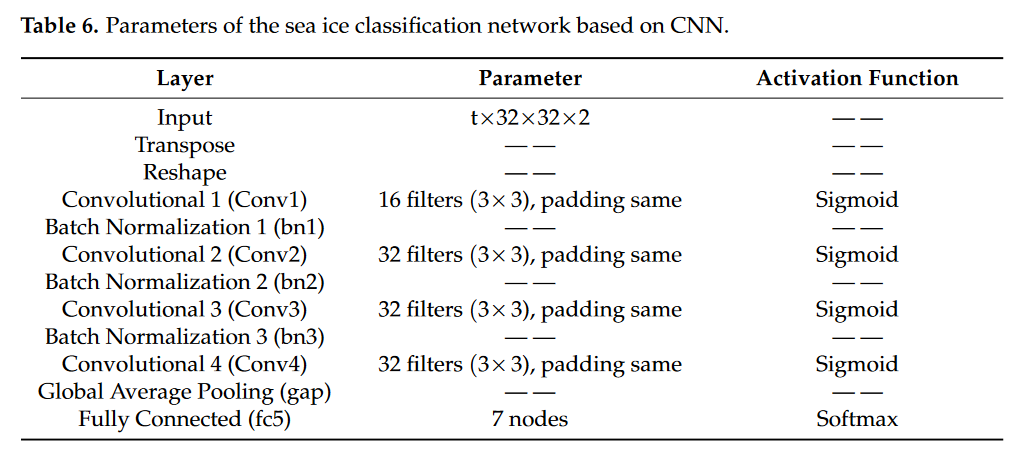

In [10]:
from tensorflow.keras.layers import Conv2D, Input, Reshape, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

# manually transposed input shape. before (6, 32, 32, 2), now (2, 32, 32, 6)
model.add(Input(shape=(2, 32, 32, 6)))

# reshape??? maybe combine the time and channels into one dimension
model.add(Reshape((32, 32, 6 * 2)))  #reshape to (32, 32, 12) for 2D CNN

## Conv1
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

## Conv2
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

## Conv3
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

## Conv4
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='sigmoid'))

## Global Average Pooling (gap)
model.add(GlobalAveragePooling2D())

model.add(Dropout(0.4))

## fully connected (fc5)
model.add(Dense(7, activation='softmax'))


# model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model training
model.fit(X_train, y_train, epochs=10, batch_size=None, validation_data=(X_val, y_val), callbacks=[early_stop])



Epoch 1/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 89s 21ms/step - accuracy: 0.4249 - loss: 1.4428 - val_accuracy: 0.6024 - val_loss: 1.0407
Epoch 2/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 84s 20ms/step - accuracy: 0.5831 - loss: 1.0487 - val_accuracy: 0.6635 - val_loss: 0.8774
Epoch 3/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 84s 20ms/step - accuracy: 0.6561 - loss: 0.8643 - val_accuracy: 0.1278 - val_loss: 10.0348
Epoch 4/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 85s 21ms/step - accuracy: 0.7293 - loss: 0.6751 - val_accuracy: 0.4351 - val_loss: 1.8599
Epoch 5/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 85s 21ms/step - accuracy: 0.7612 - loss: 0.5962 - val_accuracy: 0.1636 - val_loss: 5.8385


In [11]:
# evaluate the model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6590 - loss: 0.8793
Test accuracy: 0.6596584916114807


In [12]:
model.save('conv2D_model.keras')

# 3D CNN - Conv3D

Actually, this model works without overfitting even without Dropout and EarlyStopping. I just wanted to make sure.

In [16]:
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# 3D CNN model
model = Sequential()

model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=(6, 32, 32, 2)))
model.add(MaxPool3D(pool_size=(2, 2, 2))) #pooling improves performance

model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
model.add(MaxPool3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))     
#model.add(MaxPool3D(pool_size=(2, 2, 2))) #ValueError: Exception encountered when calling MaxPooling3D.call(). Negative dimension size caused by subtracting 2 from 1 for '{{...
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Flatten()) #3D to 1D vector

#actually this model works nicely without overfitting and there seems to be no need for Dropout, but I put it in to be safe
model.add(Dropout(0.4))

model.add(Dense(7, activation='softmax'))

# model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) #this time patience=2, the model is very stable 
# model training
model.fit(X_train, y_train, epochs=10, batch_size=None, validation_data=(X_val, y_val), callbacks=[early_stop])


Epoch 1/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7492 - loss: 0.5929 - val_accuracy: 0.8217 - val_loss: 0.4007
Epoch 2/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.8319 - loss: 0.3782 - val_accuracy: 0.8514 - val_loss: 0.3310
Epoch 3/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.8450 - loss: 0.3556 - val_accuracy: 0.8472 - val_loss: 0.3422
Epoch 4/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.8485 - loss: 0.3382 - val_accuracy: 0.8618 - val_loss: 0.2990
Epoch 5/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.8555 - loss: 0.3268 - val_accuracy: 0.8662 - val_loss: 0.3078
Epoch 6/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.8594 - loss: 0.3164 - val_accuracy: 0.8755 - val_loss: 0.2791
Epoch 7/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.8555 - loss: 0.3265 - val_accuracy: 0.8619 - val_loss: 0.3029
Epoch 8/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.8633 - loss: 0

In [17]:
# evaluate the model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8720 - loss: 0.2849
Test accuracy: 0.8695387840270996


In [18]:
model.save('3Dcnn_model.keras')

# Mix of ConvLSTM2D and Conv3D

In [23]:
# Mix model
model = Sequential()

## two convLSTM layers
model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='sigmoid', return_sequences=True, input_shape=(6, 32, 32, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='sigmoid', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.4))

## one conv3D layer
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPool3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dropout(0.4))

model.add(Dense(7, activation='softmax'))


# model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model training
model.fit(X_train, y_train, epochs=10, batch_size=None, validation_data=(X_val, y_val), callbacks=[early_stop])


Epoch 1/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 662s 160ms/step - accuracy: 0.7683 - loss: 0.6686 - val_accuracy: 0.8378 - val_loss: 0.4828
Epoch 2/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 637s 155ms/step - accuracy: 0.8617 - loss: 0.3228 - val_accuracy: 0.6703 - val_loss: 0.8863
Epoch 3/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 648s 157ms/step - accuracy: 0.8733 - loss: 0.2952 - val_accuracy: 0.8731 - val_loss: 0.2813
Epoch 4/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 663s 161ms/step - accuracy: 0.8808 - loss: 0.2757 - val_accuracy: 0.7712 - val_loss: 0.9902
Epoch 5/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 639s 155ms/step - accuracy: 0.8837 - loss: 0.2685 - val_accuracy: 0.2938 - val_loss: 4.7657
Epoch 6/10
4115/4115 ━━━━━━━━━━━━━━━━━━━━ 657s 160ms/step - accuracy: 0.8868 - loss: 0.2596 - val_accuracy: 0.8614 - val_loss: 0.3194


In [24]:
# evaluate the model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


515/515 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.8700 - loss: 0.2936
Test accuracy: 0.8724554777145386


In [25]:
model.save('mixConv_model.keras')